# INSTALLING PACKAGES

We install all the necessary packages to build the model

In [1]:
!pip install glom

In [2]:
!pip install yfinance

In [3]:
!pip install newspaper3k

In [4]:
!pip install bs4

In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
!pip install tweepy

In [7]:
!pip install htmldate

  Using cached chardet-4.0.0-py2.py3-none-any.whl (178 kB)
  Attempting uninstall: chardet
    Found existing installation: chardet 3.0.4
    Uninstalling chardet-3.0.4:
      Successfully uninstalled chardet-3.0.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires chardet<4,>=3.0.2, but you have chardet 4.0.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [8]:
!pip install sentencepiece

In [9]:
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [10]:
!pip install transformers[torch]==4.3

  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
    Uninstalling chardet-4.0.0:
      Successfully uninstalled chardet-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
htmldate 0.9.0 requires chardet>=4.0.0; python_version >= "3.6", but you have chardet 3.0.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.



# IMPORTING PACKAGES

Import packages for performing data extraction, cleaning, visulaization, and modelling

In [11]:
import tweepy, json

In [12]:
from glom import glom

In [13]:
import numpy as np

In [14]:
import pandas as pd

In [15]:
import math

In [16]:
from datetime import datetime, timedelta

In [17]:
import yfinance as yf

In [18]:
from bs4 import BeautifulSoup

In [19]:
import requests

In [20]:
import re

In [21]:
from newspaper import *

In [22]:
from htmldate import find_date

In [23]:
from nltk.corpus import stopwords

In [24]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

In [25]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [26]:
from transformers import pipeline

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

# COLLECTING TWITTER DATA

Getting developer access from twitter to extract historical tweets for upto 7 days

NOTE: The keys below are private and are to be kept confidential and not be misused without the owner's authorization

In [29]:
api_key = "D3a1PVON8wECC8ZB781LXEY0I"
api_secret_key = "lrrXjpTn0P2Rj1R1lH3cVn1KUA4xrTZyrRzb9Jfgwx1bKPC5Y2"
access_token = "1319681101-suDjXaeuUGiCMVoQ3ZHmwIv84CNkXbkvuSE39JK"
access_token_secret = "IvLRZh7i2PaxmXr4riVb7QZoLBOzqS3MJfDEEq9nX9oYU"

In [30]:
auth = tweepy.OAuthHandler(api_key,api_secret_key)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth)

In [31]:
def get_tweets(ticker_list, count):
  tweets = pd.DataFrame()

  for i in range(len(ticker_list)):
    results = api.search(q=ticker_list[i], lang='en', count=count)
    results = pd.DataFrame(results)
    temp = pd.DataFrame()

    temp['Timestamp'] = results[0].apply(lambda row: glom(row, 'created_at'))
    temp['Title'] = results[0].apply(lambda row: glom(row, 'text'))
    temp['Ticker'] = ticker_list[i]
    temp['Tweet ID'] = results[0].apply(lambda row: glom(row, 'id'))
    temp['User ID'] = results[0].apply(lambda row: glom(row, 'user.id'))
    temp['Name'] = results[0].apply(lambda row: glom(row, "user.screen_name"))
    temp['Followers'] = results[0].apply(lambda row: glom(row, 'user.followers_count'))
    temp['Location'] = results[0].apply(lambda row: glom(row, 'user.location'))
    tweets = tweets.append(temp)
    tweets.drop_duplicates(inplace=True)
  return tweets

Ticker list includes the name of all stocks under NIFTY Bank

Tweets containing any of these keywords are extracted

In [32]:
ticker_list = ["NIFTY BANK", 'SBIN', 'IDBI', 'AXISBANK', 'HDFCBANK', 'KOTAKBANK', 'PNB', 'ICICIBANK', 'BARODA', 'CANARA', 'INDUSIND', 'BANKINDIA', 'UNION']
count = 1000

tweets = get_tweets(ticker_list=ticker_list, count=count)

In [33]:
tweets.head()

,Timestamp,Title,Ticker,Tweet ID,User ID,Name,Followers,Location
0,2021-08-31 05:05:03,"#BuzzingStocks Buzzing Stocks: LT, Axis Bank, ...",NIFTY BANK,1432570105645387776,1145926040096612352,Nifty50trade,1799,"India, mum"
1,2021-08-31 05:03:49,BANK NIFTY FUTURES (CMP:36442): Trend is Down....,NIFTY BANK,1432569793719062531,1296139553833488384,tamilstock,532,Chennai
2,2021-08-31 05:03:43,"#LiveStocksUpdate Buzzing Stocks: LT, Axis Ban...",NIFTY BANK,1432569769669107717,1094850957010059265,INDMarketsLIVE,1802,"Mumbai, India"
3,2021-08-31 05:01:44,@Flipkart check DM,NIFTY BANK,1432569268567089155,2474926458,BANK__NIFTY,51187,"Jaipur, INDIA"
4,2021-08-31 05:00:02,#BANKNIFTYU2021 - bank nifty levels...31/08/2...,NIFTY BANK,1432568842660712454,760853978837942272,in_tradingview,54087,"Mumbai, India"


In [34]:
def firstandlastdate(dataframe):
  first = np.min(dataframe['Timestamp'])
  last = np.max(dataframe['Timestamp'])
  return first, last

In [35]:
first_tw, last_tw = firstandlastdate(tweets)

print('Starting: '+str(first_tw) +'\n' +'Ending: '+str(last_tw))

Starting: 2021-08-23 06:39:04
Ending: 2021-08-31 05:05:09


In [36]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214 entries, 0 to 99
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  1214 non-null   datetime64[ns]
 1   Title      1214 non-null   object        
 2   Ticker     1214 non-null   object        
 3   Tweet ID   1214 non-null   int64         
 4   User ID    1214 non-null   int64         
 5   Name       1214 non-null   object        
 6   Followers  1214 non-null   int64         
 7   Location   1214 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 85.4+ KB


# EXTRACTING NEWS

Functions are created to crawl webpages to get URLs, filter them, and feed it through the data extraction algorithm to get news data

In [37]:
def search_for_stocks_news_urls(ticker, url_list):
    for url in url_list:
        search_url = url.format(ticker)
        r = requests.get(search_url)
        soup = BeautifulSoup(r.text, 'html.parser')
        atags = soup.find_all('a')
        hrefs = [tag['href'] if tag.has_attr('href') else '' for tag in atags]
    return hrefs

In [38]:
def strip_unwanted_urls(urls, exclude_list):
    val = []
    for url in urls: 
        if 'https://' in url and not any(exclude_word in url for exclude_word in exclude_list):
            res = re.findall(r'(https?://\S+)', url)[0].split('&')[0]
            val.append(res)
    return list(set(val))

Newspaper3k package is used exclusively to find the publish date of each article extracted

In [39]:
def publish_date(URLs):
    publishdate = []
    for url in URLs:
        try:
            publishdate.append(str(find_date(url)))
        except:
            publishdate.append("None")
            pass
    return publishdate

In [40]:
def get_news_data(ticker_list, cleaned_urls):
    articles_info = []
    
    for ticker in ticker_list:
        links = cleaned_urls[ticker]
    
        for i in links:
            article_dict = {}
            article = Article(i)
            article.download()

            article_dict["link"] = i
            article_dict["Ticker"] = ticker

            try:
                article.parse()
                article_dict["Text"] = article.text
                article_dict["Title"] = article.title
                article.nlp()

            except ArticleException:
                article_dict["Text"] = np.nan
                article_dict["Title"] = np.nan

            articles_info.append(article_dict)

    news_data = pd.DataFrame(articles_info)
    return news_data

In [41]:
ticker_list = ["NIFTY BANK", 'SBIN', 'IDBI', 'AXISBANK', 'HDFCBANK', 'KOTAKBANK', 'PNB', 'ICICIBANK', 'BARODA', 'CANARA', 'INDUSIND', 'BANKINDIA', 'UNION']

url_list = ["https://www.google.com/search?q={}&tbm=nws"] 

raw_urls = {ticker:search_for_stocks_news_urls(ticker=ticker, url_list=url_list) for ticker in ticker_list}

In [42]:
links = []
for ticker in ticker_list:
    print('Number of URLs in '+ticker + ': '+str(len(raw_urls[ticker])))
    for link in raw_urls[ticker]:
        links.append(link)
print('Total number of raw URLs: '+str(len(links)))

Number of URLs in NIFTY BANK: 43
Number of URLs in SBIN: 40
Number of URLs in IDBI: 43
Number of URLs in AXISBANK: 41
Number of URLs in HDFCBANK: 43
Number of URLs in KOTAKBANK: 45
Number of URLs in PNB: 43
Number of URLs in ICICIBANK: 43
Number of URLs in BARODA: 43
Number of URLs in CANARA: 43
Number of URLs in INDUSIND: 43
Number of URLs in BANKINDIA: 41
Number of URLs in UNION: 41
Total number of raw URLs: 552


In [43]:
exclude_list = ['maps', 'policies', 'preferences', 'accounts', 'support']

cleaned_urls = {ticker:strip_unwanted_urls(raw_urls[ticker], exclude_list) for ticker in ticker_list}

In [44]:
links = []
for ticker in ticker_list:
    print('Number of URLs in '+ticker + ': '+str(len(cleaned_urls[ticker])))
    for link in cleaned_urls[ticker]:
        links.append(link)
print('Total number of cleaned URLs: '+str(len(links)))

Number of URLs in NIFTY BANK: 10
Number of URLs in SBIN: 9
Number of URLs in IDBI: 10
Number of URLs in AXISBANK: 10
Number of URLs in HDFCBANK: 10
Number of URLs in KOTAKBANK: 8
Number of URLs in PNB: 10
Number of URLs in ICICIBANK: 10
Number of URLs in BARODA: 10
Number of URLs in CANARA: 10
Number of URLs in INDUSIND: 9
Number of URLs in BANKINDIA: 10
Number of URLs in UNION: 10
Total number of cleaned URLs: 126


In [45]:
articles_publishdate = {ticker:publish_date(cleaned_urls[ticker]) for ticker in ticker_list}
articles_publishdate

{'AXISBANK': ['2021-08-30',
  '2021-08-18',
  '2021-08-31',
  '2021-08-30',
  '2021-08-31',
  '2021-08-31',
  '2021-08-30',
  '2021-08-30',
  '2021-08-31',
  '2021-08-31'],
 'BANKINDIA': ['2021-08-16',
  '2021-08-25',
  '2021-08-11',
  'None',
  '2021-08-10',
  '2021-08-30',
  '2021-08-13',
  '2021-08-27',
  'None',
  'None'],
 'BARODA': ['2021-08-09',
  '2021-08-17',
  '2021-08-31',
  '2021-08-06',
  'None',
  '2021-08-07',
  '2021-08-28',
  '2021-08-28',
  '2021-08-30',
  '2021-08-27'],
 'CANARA': ['2021-08-30',
  '2021-08-26',
  '2021-08-23',
  '2021-08-26',
  '2021-08-18',
  '2021-08-30',
  '2021-08-24',
  '2021-08-26',
  '2021-08-25',
  '2021-08-26'],
 'HDFCBANK': ['2021-08-30',
  '2021-08-18',
  '2021-08-25',
  '2021-08-30',
  '2021-08-25',
  '2021-08-27',
  '2021-08-23',
  '2021-08-20',
  '2021-08-02',
  '2021-08-24'],
 'ICICIBANK': ['None',
  '2021-08-25',
  '2021-08-30',
  '2021-08-06',
  '2021-08-25',
  'None',
  '2021-08-30',
  '2021-08-20',
  '2021-08-25',
  '2021-08-23'],


In [46]:
dates = []
for ticker in ticker_list:
    count = 0
    for value in articles_publishdate[ticker]:
        if value != "None":
            count = count + 1
    print('Number of URLs in '+ticker + ' with dateofpub: '+str(count))
    for date in articles_publishdate[ticker]:
        dates.append(link)  

Number of URLs in NIFTY BANK with dateofpub: 7
Number of URLs in SBIN with dateofpub: 9
Number of URLs in IDBI with dateofpub: 9
Number of URLs in AXISBANK with dateofpub: 10
Number of URLs in HDFCBANK with dateofpub: 10
Number of URLs in KOTAKBANK with dateofpub: 8
Number of URLs in PNB with dateofpub: 9
Number of URLs in ICICIBANK with dateofpub: 8
Number of URLs in BARODA with dateofpub: 9
Number of URLs in CANARA with dateofpub: 10
Number of URLs in INDUSIND with dateofpub: 8
Number of URLs in BANKINDIA with dateofpub: 7
Number of URLs in UNION with dateofpub: 9


In [47]:
dates = []
for ticker in ticker_list:
    print('Number of URLs in '+ticker + ' with dateofpub: '+str(len(articles_publishdate[ticker])))
    for date in articles_publishdate[ticker]:
        dates.append(link)

Number of URLs in NIFTY BANK with dateofpub: 10
Number of URLs in SBIN with dateofpub: 9
Number of URLs in IDBI with dateofpub: 10
Number of URLs in AXISBANK with dateofpub: 10
Number of URLs in HDFCBANK with dateofpub: 10
Number of URLs in KOTAKBANK with dateofpub: 8
Number of URLs in PNB with dateofpub: 10
Number of URLs in ICICIBANK with dateofpub: 10
Number of URLs in BARODA with dateofpub: 10
Number of URLs in CANARA with dateofpub: 10
Number of URLs in INDUSIND with dateofpub: 9
Number of URLs in BANKINDIA with dateofpub: 10
Number of URLs in UNION with dateofpub: 10


In [48]:
news_data = get_news_data(ticker_list=ticker_list, cleaned_urls=cleaned_urls)

In [49]:
dates = []
for ticker in ticker_list:
    for l in articles_publishdate[ticker]:
        dates.append(l)

news_data['Timestamp'] = dates

Articles without publish date are removed and are converted to datetime datatype so that it uniform with the stock data

In [50]:
news_data = news_data[news_data['Timestamp'] != 'None']

In [51]:
news_data['Timestamp'] = news_data['Timestamp'].apply(lambda date: datetime(int(date[:4]), int(date[5:7]), int(date[8:])))

In [52]:
def timestamp_adjuster(timestamp, start, delta):

    if timestamp >= datetime(timestamp.year,timestamp.month,timestamp.day,9,15) and timestamp <= datetime(timestamp.year,timestamp.month,timestamp.day,15,15):
        timestamp = start + math.ceil((timestamp - start) / delta) * delta

    elif timestamp > datetime(timestamp.year,timestamp.month,timestamp.day,15,15) and timestamp < datetime(timestamp.year,timestamp.month,timestamp.day)+timedelta(days=1):
        timestamp = datetime(timestamp.year,timestamp.month,timestamp.day,9,15) + timedelta(days=1)
  
    else:
        timestamp = datetime(timestamp.year,timestamp.month,timestamp.day,9,15)
  
    return timestamp

In [53]:
news_data['Timestamp'] = news_data['Timestamp'].apply(lambda x: datetime.strptime(x.strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S'))

news_data['Timestamp'] = news_data['Timestamp'].apply(lambda x: timestamp_adjuster(x, start=datetime(2020,1,1,0,15), delta=timedelta(hours=1)))

In [54]:
news_data.dropna(subset=['Text'], axis=0, inplace=True)

In [55]:
news_data['Text'] = news_data['Text'].apply(lambda x: str(x))

In [56]:
news_data.index = range(0, len(news_data))

In [57]:
news_data.head()

,link,Ticker,Text,Title,Timestamp
0,https://www.financialexpress.com/market/what-n...,NIFTY BANK,Nifty August rollover is higher than its three...,"What Nifty, Bank Nifty rollovers data says: Wh...",2021-08-27 09:15:00
1,https://www.zeebiz.com/market-news/news-nifty-...,NIFTY BANK,Nifty Bank indices were trading in the green o...,"Nifty PSU BANK up 2% - SBI, Canara Bank, BoB l...",2021-08-30 09:15:00
2,https://www.financialexpress.com/market/cafein...,NIFTY BANK,"Going ahead, we expect the index after the rec...","Nifty looks set to hit 17,200, Bank Nifty may ...",2021-08-30 09:15:00
3,https://www.zeebiz.com/market-news/news-stock-...,NIFTY BANK,Stock Markets on Monday - The stocks markets s...,Stock Markets Outlook – Anil Singhvi gives Nif...,2021-08-29 09:15:00
4,https://www.livemint.com/market/stock-market-n...,NIFTY BANK,Indian stock market benchmarks Sensex and Nift...,"Nifty closes in on 17,000 as bulls take charge...",2021-08-30 09:15:00


In [58]:
first_ne, last_ne = firstandlastdate(news_data)

print('Starting: '+str(first_ne) +'\n' +'Ending: '+str(last_ne))

Starting: 2021-05-29 09:15:00
Ending: 2021-08-31 09:15:00




# GETTING STOCKS DATA

Stock data with a resolution of 1 hour is extracted from Yahoo Finance using appropriate tickers for the period where news data and tweets are available

In [59]:
def get_stocksdata(ticker_list, start, end, period, resolution):
    stocks_data = pd.DataFrame()
    for i in range(len(ticker_list)):
        temp = yf.download(tickers=[ticker_list[i-1]], start=start, end=end, auto_adjust=True, period=period, interval=resolution)
        temp['Timestamp'] = temp.index
        temp['Symbol'] = ticker_list[i-1]
        stocks_data = stocks_data.append(temp)
    return stocks_data

In [60]:
stocks_ticker_list = ["^NSEBANK", 'SBIN.NS', 'IDBI.NS', 'AXISBANK.NS', 'HDFCBANK.NS', 'KOTAKBANK.NS', 'PNB.NS', 'ICICIBANK.NS', 'BANKBARODA.NS', 'CANBK.NS', 'INDUSINDBK.NS', 'BANKINDIA.NS', 'UNIONBANK.NS'] 
start = min(first_tw, first_ne)
end = min(last_tw, last_ne)
period = '1d'
resolution = '1h'

stocks_data = get_stocksdata(ticker_list=stocks_ticker_list, start=start, end=end, period=period, resolution=resolution)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [61]:
stocks_data.index = range(1, len(stocks_data)+1)

In [62]:
stocks_data['Date'] = stocks_data['Timestamp'].apply(lambda x: x.date)

stocks_data['Time'] = stocks_data['Timestamp'].apply(lambda x: x.time)

stocks_data['Timestamp'] = stocks_data['Timestamp'].apply(lambda x: datetime.strptime(x.strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S'))

In [63]:
stocks_symbol_map = {'NIFTY BANK':"^NSEBANK", 'SBIN':'SBIN.NS', 'IDBI':'IDBI.NS', 'AXISBANK':'AXISBANK.NS', 'HDFCBANK':'HDFCBANK.NS', 
                     'KOTAKBANK':'KOTAKBANK.NS', 'PNB':'PNB.NS', 'ICICIBANK':'ICICIBANK.NS', 'BARODA':'BANKBARODA.NS', 
                     'CANARA':'CANBK.NS', 'INDUSIND':'INDUSINDBK.NS', 'BANKINDIA':'BANKINDIA.NS', 'UNION':'UNIONBANK.NS'}
symbol_stocks_map = {k:v for v,k in stocks_symbol_map.items()}

stocks_data['Ticker'] = stocks_data['Symbol'].map(symbol_stocks_map)

In [64]:
stocks_data.head()

,Open,High,Low,Close,Volume,Timestamp,Symbol,Date,Time,Ticker
1,34.700001,35.000000,34.400002,34.750000,0,2021-05-31 09:15:00,UNIONBANK.NS,2021-05-31,09:15:00,UNION
2,34.700001,34.799999,34.599998,34.750000,3370432,2021-05-31 10:15:00,UNIONBANK.NS,2021-05-31,10:15:00,UNION
3,34.750000,34.799999,34.650002,34.700001,1836495,2021-05-31 11:15:00,UNIONBANK.NS,2021-05-31,11:15:00,UNION
4,34.700001,34.799999,34.599998,34.750000,1983424,2021-05-31 12:15:00,UNIONBANK.NS,2021-05-31,12:15:00,UNION
5,34.799999,34.799999,34.650002,34.700001,1751425,2021-05-31 13:15:00,UNIONBANK.NS,2021-05-31,13:15:00,UNION


In [65]:
stocks_data = stocks_data[['Open', 'Volume', 'Ticker', 'Timestamp']]

In [66]:
for i in range(1, len(stocks_data['Timestamp'])+1):
  temp = stocks_data['Timestamp'][i]
  stocks_data['Timestamp'][i] = datetime(temp.year, temp.month, temp.day, temp.hour, temp.minute, temp.second)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
stocks_data[stocks_data['Ticker'] == 'NIFTY BANK']

,Open,Volume,Ticker,Timestamp
452,35097.449219,0,NIFTY BANK,2021-05-31 09:15:00
453,35346.601562,0,NIFTY BANK,2021-05-31 10:15:00
454,35271.699219,0,NIFTY BANK,2021-05-31 11:15:00
455,35335.050781,0,NIFTY BANK,2021-05-31 12:15:00
456,35427.750000,0,NIFTY BANK,2021-05-31 13:15:00
...,...,...,...,...
898,36312.648438,0,NIFTY BANK,2021-08-30 14:15:00
899,36342.250000,0,NIFTY BANK,2021-08-30 15:15:00
900,36367.398438,0,NIFTY BANK,2021-08-31 09:15:00
901,36328.750000,0,NIFTY BANK,2021-08-31 10:15:00




# SUMMARIZING TEXT AND PERFORMING SENTIMENT ANALYSIS

In [68]:
tweets['Timestamp'] = tweets['Timestamp'].apply(lambda x: timestamp_adjuster(timestamp=x, start=datetime(2020,1,1,0,15), delta=timedelta(hours=1)))

In [69]:
tweets = tweets[['Ticker', 'Title', 'Timestamp']]

In [70]:
tweets.columns = ['Ticker', 'Text Summary', 'Timestamp']

News data is summarized using a pre-trained model

In [71]:
summarizer = pipeline("summarization")

Downloading:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

In [72]:
Text_Summary = []
for i in range(0, len(news_data['Text'])):
  summary = summarizer(news_data['Text'][i][:512], max_length=50, min_length=25, do_sample=False)[0]['summary_text']
  Text_Summary.append(summary)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
Your max_length is set to 50, but you input_length is only 34. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 50, but you input_length is only 40. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 50, but you input_length is only 44. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)

In [73]:
news_data['Text Summary'] = Text_Summary

In [74]:
news_and_tweets = news_data[['Ticker', 'Text Summary', 'Timestamp']].append(tweets)

In [75]:
news_and_tweets.index = range(0, len(news_and_tweets['Text Summary']))

In [76]:
news_and_tweets.head()

,Ticker,Text Summary,Timestamp
0,NIFTY BANK,Nifty 50 may once again surge higher to hit f...,2021-08-27 09:15:00
1,NIFTY BANK,Nifty Bank indices were trading in the green ...,2021-08-30 09:15:00
2,NIFTY BANK,The broader market indices snapped past two w...,2021-08-30 09:15:00
3,NIFTY BANK,"The Sensex ended at 56,124.72 on Friday, gain...",2021-08-29 09:15:00
4,NIFTY BANK,"NSE Nifty 50 index ended 1.35% higher to 16,9...",2021-08-30 09:15:00


Irrelavant and insignificant words are removed and fed into FINBERT model for performing Sentiment Analysis

FINBERT is a pre-trained NLP model with weights for a corpus of words from the English language with more relevance to financial context

In [77]:
stop = stopwords.words('english')
stop[:5]

['i', 'me', 'my', 'myself', 'we']

In [78]:
news_and_tweets['Text Summary'] = news_and_tweets['Text Summary'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop]))

In [79]:
news_and_tweets.head()

,Ticker,Text Summary,Timestamp
0,NIFTY BANK,Nifty 50 may surge higher hit fresh all-time h...,2021-08-27 09:15:00
1,NIFTY BANK,Nifty Bank indices trading green Monday taking...,2021-08-30 09:15:00
2,NIFTY BANK,The broader market indices snapped past two we...,2021-08-30 09:15:00
3,NIFTY BANK,"The Sensex ended 56,124.72 Friday, gaining alm...",2021-08-29 09:15:00
4,NIFTY BANK,"NSE Nifty 50 index ended 1.35% higher 16,931 e...",2021-08-30 09:15:00


In [80]:
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

In [81]:
news_and_tweets = news_and_tweets.assign(sentiment = lambda x: x['Text Summary'].apply(lambda s: classifier(s))).assign(label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score'])))

In [82]:
news_and_tweets.head()

,Ticker,Text Summary,Timestamp,sentiment,label,score
0,NIFTY BANK,Nifty 50 may surge higher hit fresh all-time h...,2021-08-27 09:15:00,"[{'label': 'positive', 'score': 0.914567649364...",positive,0.914568
1,NIFTY BANK,Nifty Bank indices trading green Monday taking...,2021-08-30 09:15:00,"[{'label': 'neutral', 'score': 0.6990373730659...",neutral,0.699037
2,NIFTY BANK,The broader market indices snapped past two we...,2021-08-30 09:15:00,"[{'label': 'positive', 'score': 0.939797878265...",positive,0.939798
3,NIFTY BANK,"The Sensex ended 56,124.72 Friday, gaining alm...",2021-08-29 09:15:00,"[{'label': 'positive', 'score': 0.912757039070...",positive,0.912757
4,NIFTY BANK,"NSE Nifty 50 index ended 1.35% higher 16,931 e...",2021-08-30 09:15:00,"[{'label': 'positive', 'score': 0.887808799743...",positive,0.887809


In [83]:
for i in range(0, len(news_and_tweets['Timestamp'])):
  temp = news_and_tweets['Timestamp'][i]
  news_and_tweets['Timestamp'][i] = datetime(temp.year, temp.month, temp.day, temp.hour, temp.minute, temp.second)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [84]:
news_and_tweets.drop('sentiment', axis=1, inplace=True)

In [85]:
news_and_tweets.columns = ['Ticker', 'Text Summary', 'Timestamp', 'Sentiment', 'Sentiment Score']

Sentiment is represented in trading terms based on the polarity scores

Articles with neutral sentiments or low polarity scores are treated as neutral

In [86]:
for i in range(0, len(news_and_tweets['Sentiment'])):
  if news_and_tweets['Sentiment'][i] == 'positive' and news_and_tweets['Sentiment Score'][i] >= 0.6:
    news_and_tweets['Sentiment'][i] = 'Buy'
  elif news_and_tweets['Sentiment'][i] == 'negative' and news_and_tweets['Sentiment Score'][i] >= 0.6:
    news_and_tweets['Sentiment'][i] = 'Sell'
  else:
    news_and_tweets['Sentiment'][i] = 'None'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Maximum budget per transaction is limited to Rs.10000 and the cost of transaction regresses with lower sentiment polarity scores

All these figures are arbitary

In [87]:
budget_per_share = 10000
news_and_tweets['Quantity'] = np.zeros(len(news_and_tweets['Ticker']))

for i in range(0, len(news_and_tweets['Sentiment Score'])):
  try:
    tstamp = news_and_tweets.loc[i]['Timestamp']
    tick = news_and_tweets.loc[i]['Ticker']
    if news_and_tweets['Sentiment Score'][i] >= 0.9:
      news_and_tweets['Quantity'][i] = round((budget_per_share) / (stocks_data[(stocks_data['Ticker'] == tick) & (stocks_data['Timestamp'] == tstamp)]['Open']))
    elif news_and_tweets['Sentiment Score'][i] >= 0.8 and news_and_tweets['Sentiment Score'][i] < 0.9:
      news_and_tweets['Quantity'][i] = round((budget_per_share-2000) / (stocks_data[( stocks_data['Ticker'] == tick) & (stocks_data['Timestamp'] == tstamp)]['Open']))
    elif news_and_tweets['Sentiment Score'][i] >= 0.7 and news_and_tweets['Sentiment Score'][i] < 0.8:
      news_and_tweets['Quantity'][i] = round((budget_per_share-4000) / (stocks_data[(stocks_data['Ticker'] == tick) & (stocks_data['Timestamp'] == tstamp)]['Open']))
    elif news_and_tweets['Sentiment Score'][i] >= 0.6 and news_and_tweets['Sentiment Score'][i] < 0.7:
      news_and_tweets['Quantity'][i] = round((budget_per_share-6000) / (stocks_data[(stocks_data['Ticker'] == tick) & (stocks_data['Timestamp'] == tstamp)]['Open']))
    else:
      news_and_tweets['Quantity'][i] = 0
  except:
    news_and_tweets['Quantity'][i] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipyk

In [88]:
news_and_tweets.head()

,Ticker,Text Summary,Timestamp,Sentiment,Sentiment Score,Quantity
0,NIFTY BANK,Nifty 50 may surge higher hit fresh all-time h...,2021-08-27 09:15:00,Buy,0.914568,0.0
1,NIFTY BANK,Nifty Bank indices trading green Monday taking...,2021-08-30 09:15:00,None,0.699037,0.0
2,NIFTY BANK,The broader market indices snapped past two we...,2021-08-30 09:15:00,Buy,0.939798,0.0
3,NIFTY BANK,"The Sensex ended 56,124.72 Friday, gaining alm...",2021-08-29 09:15:00,Buy,0.912757,0.0
4,NIFTY BANK,"NSE Nifty 50 index ended 1.35% higher 16,931 e...",2021-08-30 09:15:00,Buy,0.887809,0.0


# MAPPING DATA AND AUTOMATION

In [89]:
nt = news_and_tweets
nt['Timestamp'] = nt['Timestamp'].apply(lambda x: pd.to_datetime(x))

In [90]:
st = stocks_data
st['Timestamp'] = st['Timestamp'].apply(lambda x: pd.to_datetime(x))

News data and stock data are merged on timestamp and by ticker values

In [91]:
df = pd.merge_asof(st.sort_values('Timestamp'), nt.sort_values('Timestamp'), by='Ticker', on='Timestamp', direction='forward')

In [92]:
df.head()

,Open,Volume,Ticker,Timestamp,Text Summary,Sentiment,Sentiment Score,Quantity
0,34.700001,0,UNION,2021-05-31 09:15:00,Match coverage begin 7:30 p.m. pre-match show ...,None,0.911753,0.0
1,737.900024,0,AXISBANK,2021-05-31 09:15:00,Edelweiss buy call Axis Bank Ltd. target price...,None,0.950895,13.0
2,643.750000,0,ICICIBANK,2021-05-31 09:15:00,ICICI Bank provides benefit investing Public P...,None,0.947343,14.0
3,1500.000000,0,HDFCBANK,2021-05-31 09:15:00,HDFC Bank (NYSE:HDB) upgraded Zacks Investment...,Buy,0.943182,7.0
4,83.000000,0,BARODA,2021-05-31 09:15:00,CNN.com feature iReporters world weekly Travel...,None,0.936466,121.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 1.0, 'NIFTY BANK')

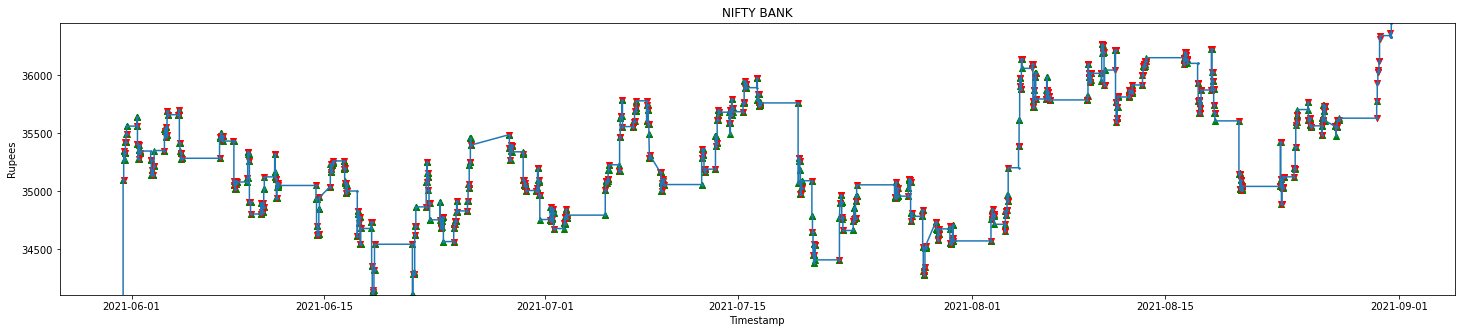

In [93]:
temp = df[['Timestamp', 'Open', 'Quantity', 'Ticker', 'Sentiment']]
for i in range(1, len(temp['Timestamp'])):
  if temp['Ticker'][i] != 'NIFTY BANK':
    temp['Open'][i] = temp['Open'][i-1]

fig, ax = plt.subplots(figsize=(25,5))
plt.plot(temp['Timestamp'], temp['Open'], marker='o', markersize=1)
ax.scatter(temp[(temp['Sentiment']=='Buy')]['Timestamp'], temp[(temp['Sentiment']=='Buy')]['Open'], marker='^', c='g')
ax.scatter(temp[(temp['Sentiment']=='Sell')]['Timestamp'], temp[(temp['Sentiment']=='Sell')]['Open'], marker='v', c='r')
ax.set_ylim([min(temp[temp['Ticker']=='NIFTY BANK']['Open']), max(temp[temp['Ticker']=='NIFTY BANK']['Open'])])
ax.set_xlabel('Timestamp')
ax.set_ylabel('Rupees')
ax.set_title('NIFTY BANK')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/IPyt

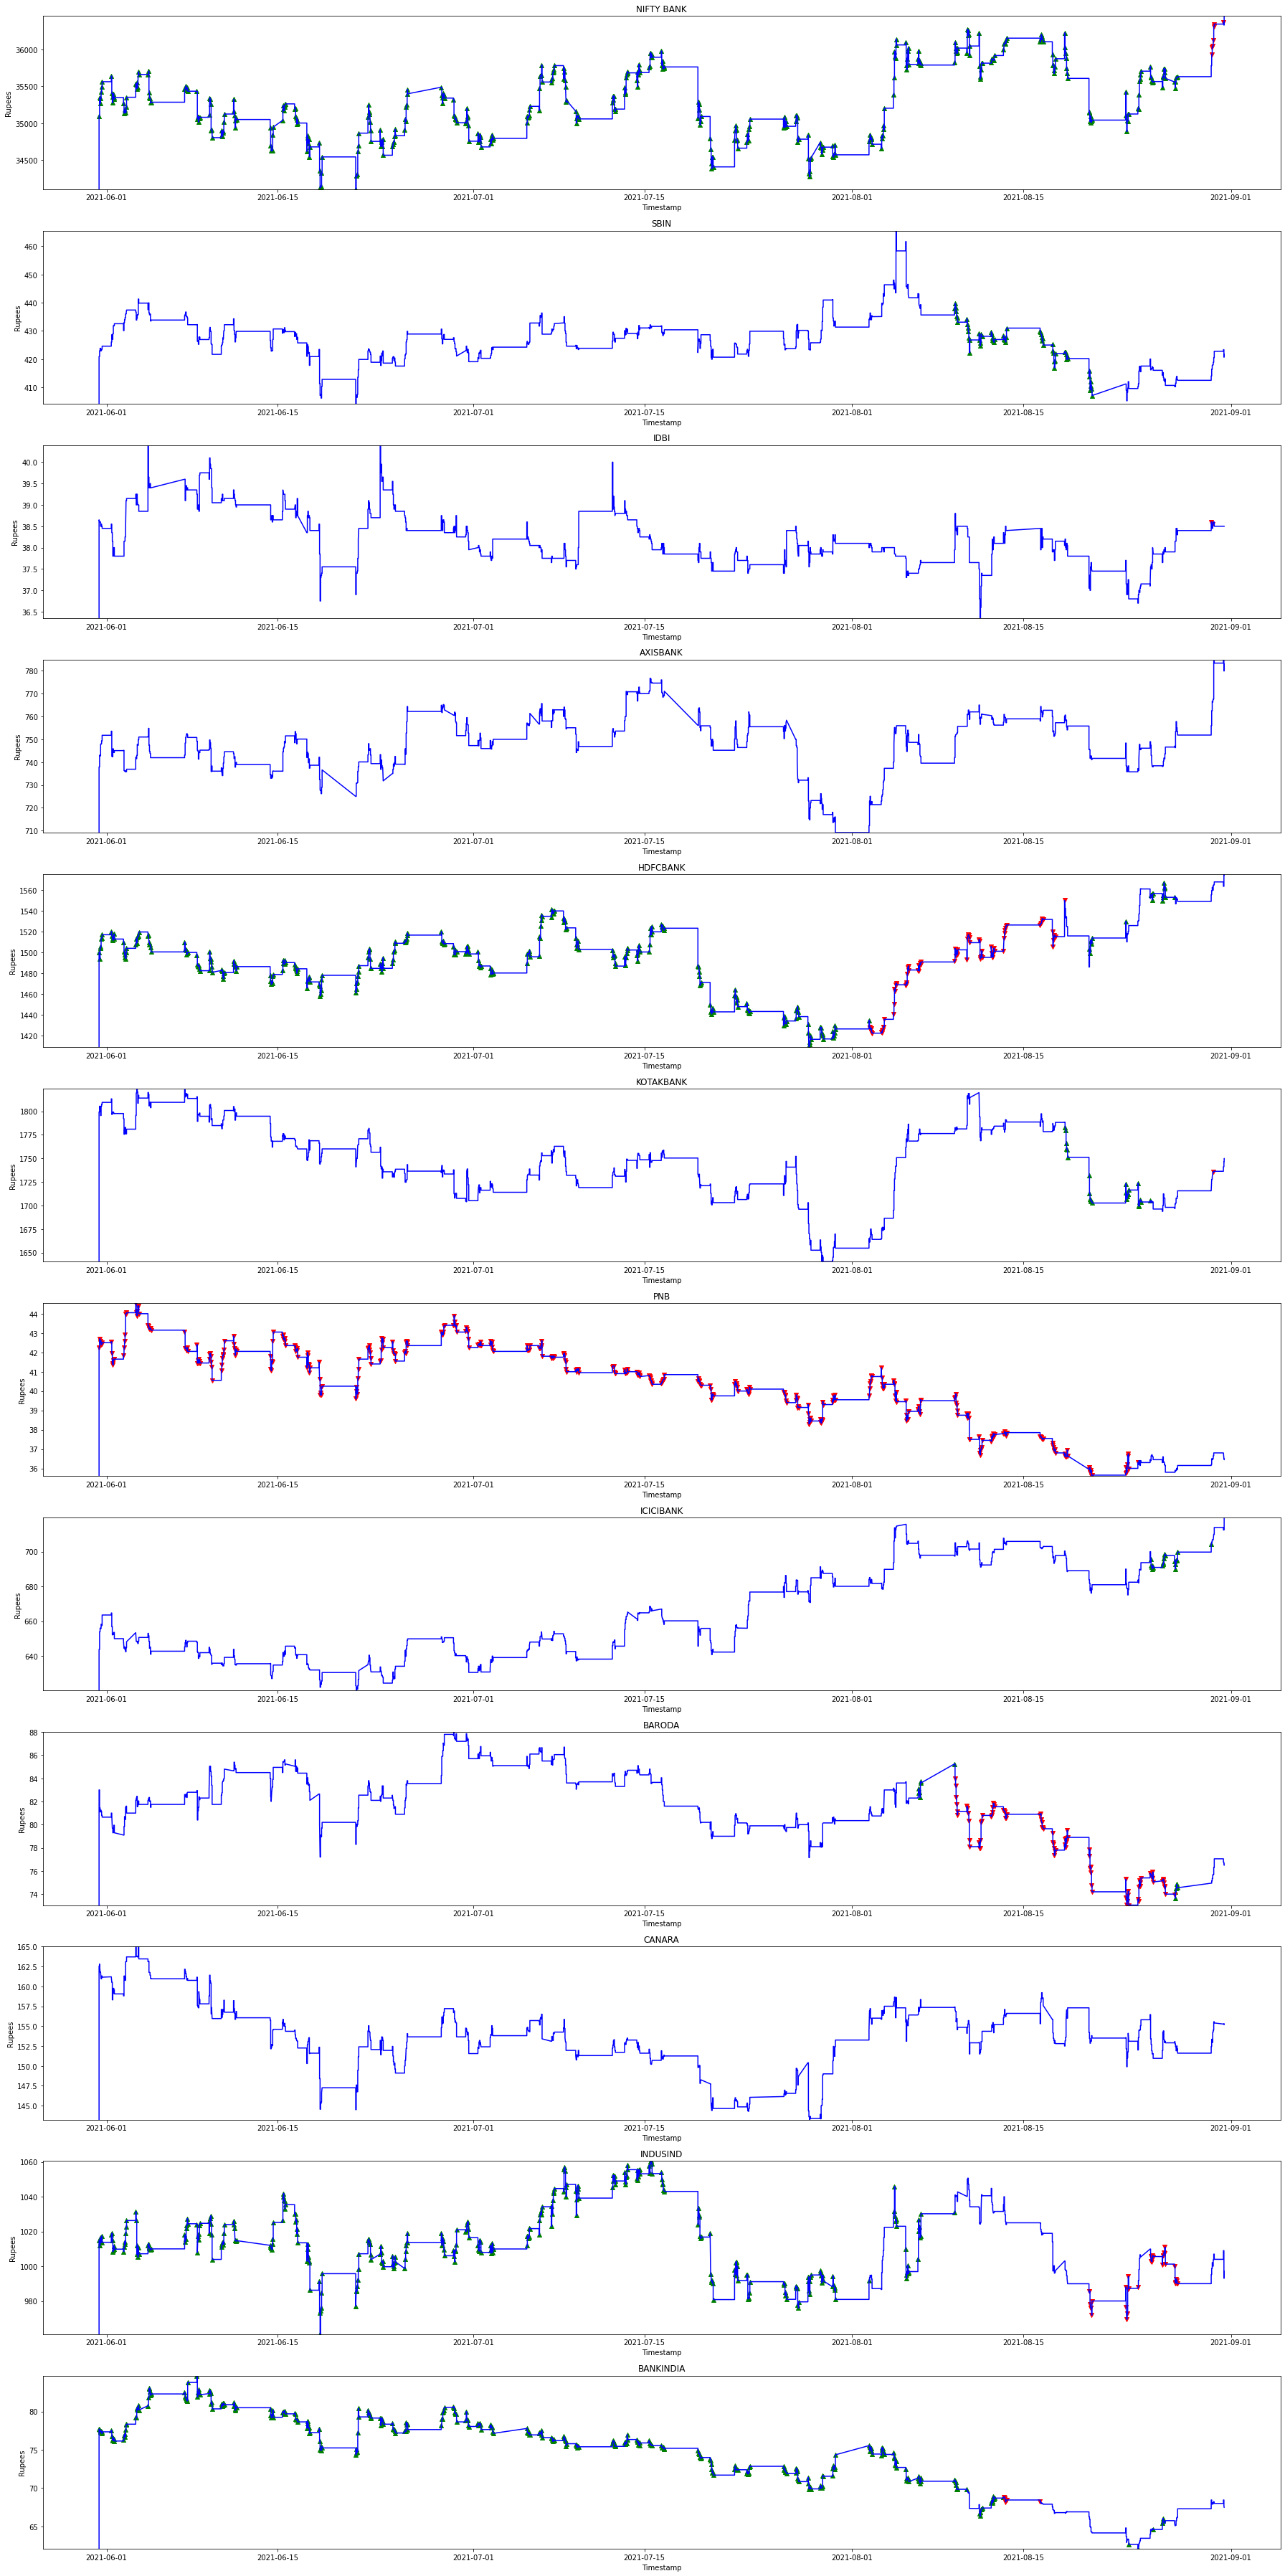

In [94]:
fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(25,50))
tl = ticker_list

for t in range(0, len(tl)-1):
  temp = df[['Timestamp', 'Open', 'Quantity', 'Ticker', 'Sentiment']]
  for i in range(1, len(temp['Timestamp'])):
    if temp['Ticker'][i] != tl[t]:
      temp['Open'][i] = temp['Open'][i-1]

  axes[t].plot(temp['Timestamp'], temp['Open'], c='b')
  axes[t].scatter(temp[(temp['Sentiment']=='Buy') & (temp['Ticker']==tl[t])]['Timestamp'], temp[(temp['Sentiment']=='Buy') & (temp['Ticker']==tl[t])]['Open'], marker='^', c='g')
  axes[t].scatter(temp[(temp['Sentiment']=='Sell') & (temp['Ticker']==tl[t])]['Timestamp'], temp[(temp['Sentiment']=='Sell') & (temp['Ticker']==tl[t])]['Open'], marker='v', c='r')
  axes[t].set_ylim([min(temp[temp['Ticker']==tl[t]]['Open']), max(temp[temp['Ticker']==tl[t]]['Open'])])
  axes[t].set_xlabel('Timestamp')
  axes[t].set_ylabel('Rupees')
  axes[t].set_title(tl[t])
  plt.tight_layout()

Now, we simulate the trading through the period to arrive at the amount invested and earned based on investor sentiments

In [144]:
portfolio = {ticker:0 for ticker in ticker_list}
bank = {ticker:0 for ticker in ticker_list}
temp = df.dropna()

for i in range(len(temp['Timestamp'])-1):
  n_buy = {ticker:0 for ticker in ticker_list}
  n_sell = {ticker:0 for ticker in ticker_list}
  if temp['Sentiment'][i] == 'Buy' and n_buy[temp['Ticker'][i]] <= 3:
    buy_qty = temp['Quantity'][i] 
    cost_buy = buy_qty * temp['Open'][i]
    if portfolio[temp['Ticker'][i]] * temp['Open'][i] <= 10000:
      portfolio[temp['Ticker'][i]] += buy_qty
      bank[temp['Ticker'][i]] -= cost_buy
      n_buy[temp['Ticker'][i]] += 1
      n_sell[temp['Ticker'][i]] -= 1
  elif temp['Sentiment'][i] == 'Sell' and n_sell[temp['Ticker'][i]] <= 3:
    sell_qty = temp['Quantity'][i] 
    cost_sell = sell_qty * temp['Open'][i]
    if portfolio[temp['Ticker'][i]] * temp['Open'][i] <= 10000:
      portfolio[temp['Ticker'][i]] -= sell_qty
      bank[temp['Ticker'][i]] += cost_sell
      n_buy[temp['Ticker'][i]] -= 1
      n_sell[temp['Ticker'][i]] += 1 
  else:
    bank[temp['Ticker'][i]] += 0

sum = 0
value = 0
for ticker in {ticker:0 for ticker in ticker_list[1:]}:
  quantity = portfolio[ticker]
  price = round(temp[temp['Ticker'] == ticker].iloc[-1]['Open'], 2)
  value = round(quantity * price, 2)
  print(ticker +' : \n' +'Quantity = ' +str(quantity) +'\n' +'Price = ' +str(price) +'\n' +'Value = ' +str(value) +'\n' +'Bank = ' +str(round(bank[ticker])))
  print('\n')
  sum += value

bank_total = 0
for i in ([bank[ticker] for ticker in ticker_list[1:]]):
  bank_total += i

print('\n')  
print('Total Value (Position) of Portfolio at end: \n' 
      +'Bank = ' +str(round(bank_total)) +'\n'
      +'Portfolio = ' +str(round(sum)) +'\n'
      +'Total = ' +str(round(bank_total + sum)))

SBIN : 
Quantity = 0.0
Price = 423.35
Value = 0.0
Bank = 0


IDBI : 
Quantity = -415.0
Price = 38.5
Value = -15977.5
Bank = 16009


AXISBANK : 
Quantity = 0
Price = 784.9
Value = 0.0
Bank = 0


HDFCBANK : 
Quantity = 14.0
Price = 1563.5
Value = 21889.0
Bank = -20461


KOTAKBANK : 
Quantity = 10.0
Price = 1741.15
Value = 17411.5
Bank = -17814


PNB : 
Quantity = -91080.0
Price = 36.8
Value = -3351744.0
Bank = 3700928


ICICIBANK : 
Quantity = 28.0
Price = 712.4
Value = 19947.2
Bank = -19426


BARODA : 
Quantity = -10490.0
Price = 76.75
Value = -805107.5
Bank = 820135


CANARA : 
Quantity = 0
Price = 155.25
Value = 0.0
Bank = 0


INDUSIND : 
Quantity = 20.0
Price = 1009.0
Value = 20180.0
Bank = -20012


BANKINDIA : 
Quantity = 172.0
Price = 68.45
Value = 11773.4
Bank = -13356


UNION : 
Quantity = -175.0
Price = 34.85
Value = -6098.75
Bank = 6011




Total Value (Position) of Portfolio at end: 
Bank = 4452013
Portfolio = -4087727
Total = 364287


Similarly, we automate an alternate scenario where the same amount of money is invested in the NIFTY Bank index fund at the same time instead of individual stocks

In [147]:
bank = 0
temp = df.dropna()
index_qty = 0

for i in range(len(temp['Timestamp'])-1):
  if temp['Sentiment'][i] == 'Buy':
    buy_qty = temp['Quantity'][i] 
    cost_buy = buy_qty * temp['Open'][i]
    index_price = temp[(temp['Ticker'] == 'NIFTY BANK') & (temp['Timestamp'] == temp['Timestamp'][i])].iloc[-1]['Open']
    if cost_buy <= 10000:
      index_qty += cost_buy / index_price
      bank -= cost_buy
  elif temp['Sentiment'][i] == 'Sell':
    sell_qty = temp['Quantity'][i]
    cost_sell = sell_qty * temp['Open'][i]
    index_price = temp[(temp['Ticker'] == 'NIFTY BANK') & (temp['Timestamp'] == temp['Timestamp'][i])].iloc[-1]['Open']
    index_qty -= cost_sell / index_price
    bank += cost_sell
  else:
    bank += 0

price = temp[temp['Ticker'] == 'NIFTY BANK'].iloc[-1]['Open']
index_fund = index_qty * price
print('Bank = ' +str(round(bank)) +'\n')
print('Index Quantity = ' +str(index_qty) +' Index Price = ' +str(round(price)) +' Index Fund = ' +str(round(index_fund)) +'\n')
print('Total Value (Position) of NIFTY BANK fund at end = ' +str(round(bank + index_fund)))

Bank = 1161221

Index Quantity = -32.01161117377999 Index Price = 36367 Index Fund = -1164179

Total Value (Position) of NIFTY BANK fund at end = -2959


It is evident that the results are better when traded using the model